In [ ]:
!pip install pyspark
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori as apr3, association_rules
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
import json

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 56.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=eebae6263b434f9bd898f3e66b19c5e5d712149a002c40e3a46d1113ad0fa928
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
f = open('/content/drive/My Drive/pokemonTeamsAll.json', 'r')

Mounted at /content/drive


In [ ]:
# f = open("pokemonTeamsAll.json")
data = json.load(f)
final_teams = []
mons = []
for i in range(int(len(data["teams"])/8)):
    pokemonArray = data["teams"][i]
    for mon in pokemonArray:
      if mon not in mons:
        mons.append(mon)
    final_teams.append(tuple(pokemonArray))
    

In [ ]:
nums_of_mons = []
for team in final_teams:
    mons_there = []
    for mon in mons:
        if mon in team:
            mons_there.append(True)
        else:
            mons_there.append(False)

    nums_of_mons.append(mons_there)


In [ ]:
data = np.array(nums_of_mons)
processed_data = pd.DataFrame(nums_of_mons, columns=mons)

# Building the model
frq_items = apr3(processed_data, min_support=0.0001, use_colnames=True)


In [ ]:
# Collecting the inferred rules in a dataframe
rules = association_rules(frq_items, metric="lift", min_threshold=0.01)
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
664067,"(Zekrom, Obstagoon, Whimsicott)","(Escavalier, Zacian-Crowned, Charizard)",0.000103,0.000103,0.000103,1.000000,9750.725806,0.000103,inf
664086,"(Escavalier, Zacian-Crowned, Charizard)","(Zekrom, Obstagoon, Whimsicott)",0.000103,0.000103,0.000103,1.000000,9750.725806,0.000103,inf
605675,"(Reuniclus, Groudon, Indeedee-F)","(Calyrex-Ice, Togekiss, Marowak-Alola)",0.000101,0.000104,0.000101,1.000000,9595.952381,0.000101,inf
605682,"(Togekiss, Marowak-Alola, Indeedee-F)","(Calyrex-Ice, Reuniclus, Groudon)",0.000101,0.000106,0.000101,1.000000,9446.015625,0.000101,inf
610740,"(Torkoal, Calyrex-Ice, Mimikyu, Zoroark)","(Trevenant, Eternatus)",0.000109,0.000109,0.000109,1.000000,9159.772727,0.000109,inf
...,...,...,...,...,...,...,...,...,...
529947,(Incineroar),"(Rillaboom, Groudon, Zacian-Crowned, Grimmsnarl)",0.468718,0.001174,0.000101,0.000215,0.183299,-0.000450,0.999041
26123,(Incineroar),"(Dracovish, Indeedee-F)",0.468718,0.001365,0.000101,0.000215,0.157748,-0.000539,0.998850
203152,(Incineroar),"(Hitmontop, Mimikyu, Kyogre)",0.468718,0.001416,0.000101,0.000215,0.152035,-0.000563,0.998799
81078,(Incineroar),"(Umbreon, Ho-Oh)",0.468718,0.001889,0.000101,0.000215,0.113960,-0.000785,0.998326


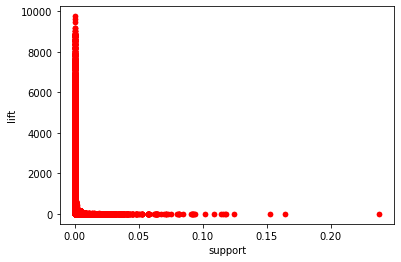

In [ ]:
rules.plot(kind='scatter',x='support', y='lift',color='red')

In [9]:
rules["antecedents"] = rules["antecedents"].apply(list)
rules["consequents"] = rules["consequents"].apply(list)

df = spark.createDataFrame(rules)

df.createOrReplaceTempView("association_rules")
ordered_rules = spark.sql("select * from association_rules ORDER BY (confidence,lift) DESC").createOrReplaceTempView("ordered_view")

step_one = """
          SELECT consequents 
          FROM ordered_view 
          WHERE array_contains(antecedents,{pokemon1})
              AND cardinality(antecedents) = {arr_size}
          ORDER BY ("confidence","lift")
         """
step_two = """
          SELECT consequents 
          FROM ordered_view 
          WHERE array_contains(antecedents,{pokemon1})
              AND array_contains(antecedents,{pokemon2})
              AND cardinality(antecedents) = {arr_size}
          ORDER BY ("confidence","lift")
         """
step_three = """
          SELECT consequents 
          FROM ordered_view 
          WHERE array_contains(antecedents,{pokemon1})
              AND array_contains(antecedents,{pokemon2})
              AND array_contains(antecedents,{pokemon3})
              AND cardinality(antecedents) = {arr_size}
          ORDER BY ("confidence","lift")
         """
step_four = """
          SELECT consequents 
          FROM ordered_view 
          WHERE array_contains(antecedents,{pokemon1})
              AND array_contains(antecedents,{pokemon2})
              AND array_contains(antecedents,{pokemon3})
              AND array_contains(antecedents,{pokemon4})
              AND cardinality(antecedents) = {arr_size}
          ORDER BY ("confidence","lift")
         """
step_five = """
          SELECT consequents 
          FROM ordered_view 
          WHERE array_contains(antecedents,{pokemon1})
              AND array_contains(antecedents,{pokemon2})
              AND array_contains(antecedents,{pokemon3})
              AND array_contains(antecedents,{pokemon4})
              AND array_contains(antecedents,{pokemon5})
              AND cardinality(antecedents) = {arr_size}
          ORDER BY ("confidence","lift")
         """



What are your initial Pokemon? Please separate by comma: Landorus-Therian
Based your current team draft, our suggestion is 
['Zacian-Crowned']
Do your want to accept it or try a new suggestion? (accept/reject): accept
Your current draft is: 
['Landorus-Therian', 'Zacian-Crowned']
Based your current team draft, our suggestion is 
['Grimmsnarl']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Incineroar']
Do your want to accept it or try a new suggestion? (accept/reject): accept
Your current draft is: 
['Landorus-Therian', 'Zacian-Crowned', 'Incineroar']
Based your current team draft, our suggestion is 
['Regieleki']
Do your want to accept it or try a new suggestion? (accept/reject): accept
Your current draft is: 
['Landorus-Therian', 'Zacian-Crowned', 'Incineroar', 'Regieleki']
Based your current team draft, our suggestion is 
['Yveltal']
Do your want to accept it or try a new suggestion? (accept/reject): accept
Your current d

In [12]:
#build a pokemon team step by step

input_pokemon = input("What are your initial Pokemon? Please separate by comma: ")
final_choices = input_pokemon.split(",")

#continue running until there are 6 pokemons on the team
while(len(final_choices) < 6):
  #run the SQL queries in different scenarios
  if len(final_choices) == 1:
    suggestions = spark.sql(step_one.format(pokemon1='"%s"'%final_choices[0],arr_size=len(final_choices))).collect()
  elif len(final_choices) == 2:
    suggestions = spark.sql(step_two.format(pokemon1='"%s"'%final_choices[0],pokemon2='"%s"'%final_choices[1],arr_size=len(final_choices))).collect()
  elif len(final_choices) == 3:
    suggestions = spark.sql(step_three.format(pokemon1='"%s"'%final_choices[0],pokemon2='"%s"'%final_choices[1],pokemon3='"%s"'%final_choices[2],arr_size=len(final_choices))).collect()
  elif len(final_choices) == 4:
    suggestions = spark.sql(step_four.format(pokemon1='"%s"'%final_choices[0],pokemon2='"%s"'%final_choices[1],pokemon3='"%s"'%final_choices[2],pokemon4='"%s"'%final_choices[3],arr_size=len(final_choices))).collect()
  elif len(final_choices) == 5:
    suggestions = spark.sql(step_five.format(pokemon1='"%s"'%final_choices[0],pokemon2='"%s"'%final_choices[1],pokemon3='"%s"'%final_choices[2],pokemon4='"%s"'%final_choices[3],pokemon5='"%s"'%final_choices[4],arr_size=len(final_choices))).collect()
  cur_index = 0
  pick = suggestions[cur_index][0]

  #added the accept/reject functionality
  print("Based your current team draft, our suggestion is ")
  print(pick)
  decision = input("Do your want to accept it or try a new suggestion? (accept/reject): ")
  while(decision != "accept"):
    cur_index += 1
    pick = suggestions[cur_index][0]
    print("Here is another recommendation ")
    print(pick)
    decision = input("Do your want to accept it or try a new suggestion? (accept/reject): ")
  #add the recommended pokemon to the team
  if len(pick)==1:
    final_choices.append(pick[0])
  else:
    for item in pick:
      final_choices.append(item)
  print("Your current draft is: ")
  print(final_choices)

What are your initial Pokemon? Please separate by comma: Landorus-Therian
Based your current team draft, our suggestion is 
['Zacian-Crowned']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Grimmsnarl']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Incineroar']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Kyogre']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Regieleki']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Yveltal']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Rillaboom']
Do your want to accept it or try a new suggestion? (accept/reject): reject
Here is another recommendation 
['Zacian-Crowned', 'Grimmsn